# IMPORT THE PACKAGES NEEEDED

In [31]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import keras_tuner as kt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


## LOAD ALL THE FILES NEEDED


Steady_state_transients_df---->  DataFrame of examples for both steady state and transients Active Power, Frequency, Voltage, and Reactive Power
Steady_state_transients_df---->  numpy of target for both steady state and transients Active Power, Frequency, Voltage, and Reactive Power

load_changes_incr_dcr_df---->  DataFrame of examples for both incremental and decremental load change- Active Power, Frequency, Voltage, and Reactive Power
load_changes_incr_dcr_df---->  numpy of target for both incremental and decremental load change- Active Power, Frequency, Voltage, and Reactive Power

breaker_opening_df---->  DataFrame of examples for breaker opening :Active Power, Frequency, Voltage, and Reactive Power
breaker_opening_df---->  numpy of target for breaker opening: Active Power, Frequency, Voltage, and Reactive Power

sensor_fault_df---->  DataFrame of examples for sensor fault: Active Power, Frequency, Voltage, and Reactive Power
sensor_fault_df---->  numpy of target for sensor fault: Active Power, Frequency, Voltage, and Reactive Power

stealthy_FDIA_df---->  DataFrame of examples for stealthy FDIA: Active Power, Frequency, Voltage, and Reactive Power
stealthy_FDIA_df---->  numpy of target for stealthy FDIA: Active Power, Frequency, Voltage, and Reactive Power

FDIA_df---->  DataFrame of examples for FDIA: Active Power, Frequency, Voltage, and Reactive Power
FDIA_df---->  numpy of target for FDIA: Active Power, Frequency, Voltage, and Reactive Power

In [2]:
waveform_1 = joblib.load('Steady_state_transients_df')
targets_1 = joblib.load('Steady_state_transients_np')

waveform_2 = joblib.load('load_changes_incr_dcr_df')
targets_2 = joblib.load('load_changes_incr_dcr_np')

waveform_3 = joblib.load('breaker_opening_df')
targets_3 = joblib.load('breaker_opening_np')

waveform_4 = joblib.load('sensor_fault_df')
targets_4 = joblib.load('sensor_fault_np')

waveform_5 = joblib.load('stealthy_FDIA_df')
targets_5 = joblib.load('stealthy_FDIA_np')

waveform_6 = joblib.load('fdia_df.joblib')
targets_6 = joblib.load('fdia.joblib')


# Confirm that every class size is made up of 400 examples

### The integar representing the False data injection attack is represented as 8 but is changed to 7, making the class representations orderly...It is zero indexed

In [4]:
targets_6[targets_6 == [8]] = [7]

In [5]:
print(np.unique(targets_1, return_counts=True))
print(np.unique(targets_2, return_counts=True))
print(np.unique(targets_3, return_counts=True))
print(np.unique(targets_4, return_counts=True))
print(np.unique(targets_5, return_counts=True))
print(np.unique(targets_6, return_counts=True))

(array([0., 1.]), array([400, 400], dtype=int64))
(array([2., 3.]), array([400, 400], dtype=int64))
(array([4]), array([400], dtype=int64))
(array([5.]), array([400], dtype=int64))
(array([6]), array([400], dtype=int64))
(array([7]), array([400], dtype=int64))


## Create a list to contain tuples of the predictors prefixed with `waveform` and targets prefixed with `targets` so that they map to each other

In [6]:
all_events = [
    (waveform_1, targets_1), 
    (waveform_2, targets_2), 
    (waveform_3, targets_3), 
    (waveform_4, targets_4), 
    (waveform_5, targets_5), 
    (waveform_6, targets_6),
]


## Create one dataframe to house all the examples of every class or scenario and one numpy array representing the class from 0 to 7
 In the dataframe for all examples, every 1000 samples is an instance

0 - Transient

1- Steady State

2 - Incremental Load change

3 - Decremental load change

4 - Breaker opening

5 - Sensor fault

6 - Stealthy FDIA

7 - FDIA


In [7]:
for i, (power, pred_class) in enumerate(all_events):
    if i == 0:
        building_block = power
        building_arr = pred_class
    else:
        building_block = pd.concat(
            (building_block, power), ignore_index=True, axis=0
        )
        building_arr = np.append(building_arr, pred_class, axis=0)

waveform = building_block
all_targets = building_arr
    

### There are a total of 3_200 instances meaning that there would be 3_200_000 rows in the dataframe capturing all examples: `waveform`

In [8]:
print(waveform.shape, all_targets.shape)
n_instances = all_targets.shape[0]
print(n_instances)

(3200000, 12) (3200, 1)
3200


## Confirm pnce again the class size of each class in the numpy array for all targets `all_targets`

In [9]:
np.unique(all_targets, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7.]),
 array([400, 400, 400, 400, 400, 400, 400, 400], dtype=int64))

### Create template to organise the shape of the dataframe to hold all the instances synthesized. A multidimensional numpy is used for this....Each is gonna be 1000 by 3, 3 columns for active Power alone in all 3 phases.....This is where the other variables are dropped: Reactive power, Frequency, and voltage

In [10]:
predictors = np.empty(shape=(0, 1000, 3))

In [11]:
start, end = 0, 1
for i in range(n_instances):
    arr = np.array([waveform.iloc[start * 1_000: end * 1_000, 0:3].to_numpy(),])
    predictors = np.append(predictors, arr, axis=0)
    start += 1
    end += 1

### There are 3_200 total instances, each have a dimension of 1_000 samples in 0.5 seconds for Active power in 3 lines

In [12]:
predictors.shape

(3200, 1000, 3)

## Use the test_train_split function imported to split the dataset into training and testing pairs, 30 percent for testing and 70 percent for training  

In [14]:
X_train, X_test, y_train, y_test = train_test_split(predictors, all_targets, test_size=0.3, random_state=42)

In [15]:
def model_builder(hp):
    model = keras.Sequential()
    #######################################
    n_filters_1 = hp.Int('n_filters_convlayer1', min_value = 4, max_value=200, step=4)
    kernel_1 = hp.Int('Kernel_convlayer_1', min_value=1, max_value=4, step=1)
    padding_1 = hp.Choice('padding_1', values=['valid', 'same', 'causal'])
    strides_1 = hp.Choice('strides_1', values=[1, 2, 3])
    n_filters_2 = hp.Int('n_filters_convlayer2', min_value = 4, max_value=200, step=4)
    kernel_2 = hp.Int('Kernel_convlayer_2', min_value=1, max_value=4, step=1)
    padding_2 = hp.Choice('padding_2', values=['valid', 'same', 'causal'])
    strides_2 = hp.Choice('strides_2', values=[1, 2,])
    n_filters_3 = hp.Int('n_filters_convlayer3', min_value = 4, max_value=200, step=4)
    kernel_3 = hp.Int('Kernel_convlayer_3', min_value=1, max_value=4, step=1)
    padding_3 = hp.Choice('padding_3', values=['valid', 'same', 'causal'])
    strides_3 = hp.Choice('strides_3', values=[1, 2,])
    pool_1 = hp.Int('pool_1', min_value=2, max_value=4, step=1)
    pool_2 = hp.Int('pool_2', min_value=2, max_value=8, step=1)
    #####################################################################
    n_filters_4 = hp.Int('n_filters_convlayer4', min_value = 4, max_value=200, step=4)
    kernel_4 = hp.Int('Kernel_convlayer_4', min_value=1, max_value=4, step=1)
    padding_4 = hp.Choice('padding_4', values=['valid', 'same', 'causal'])
    strides_4 = hp.Choice('strides_4', values=[1, 2,])
    n_filters_5 = hp.Int('n_filters_convlayer5', min_value = 4, max_value=200, step=4)
    kernel_5 = hp.Int('Kernel_convlayer_5', min_value=1, max_value=4, step=1)
    padding_5 = hp.Choice('padding_5', values=['valid', 'same', 'causal'])
    strides_5 = hp.Choice('strides_5', values=[1, 2, ])
    n_filters_6 = hp.Int('n_filters_convlayer6', min_value = 4, max_value=200, step=4)
    kernel_6 = hp.Int('Kernel_convlayer_6', min_value=1, max_value=4, step=1)
    padding_6 = hp.Choice('padding_6', values=['valid', 'same', 'causal'])
    strides_6 = hp.Choice('strides_6', values=[1, 2, ])
    n_filters_7 = hp.Int('n_filters_convlayer7', min_value = 4, max_value=200, step=4)
    kernel_7 = hp.Int('Kernel_convlayer_7', min_value=1, max_value=3, step=1)
    padding_7 = hp.Choice('padding_7', values=['valid', 'same', 'causal'])
    strides_7 = hp.Choice('strides_7', values=[1, 2, 3,])
    ###################################################################
    model.add(layers.Conv1D(filters=n_filters_1, kernel_size=(kernel_1), activation='relu', input_shape=(1000, 3), padding=padding_1, strides=strides_1))
    model.add(layers.Conv1D(filters=n_filters_2, kernel_size=(kernel_2), activation='relu', padding=padding_2, strides=strides_2))
    model.add(layers.Conv1D(filters=n_filters_3, kernel_size=(kernel_3), activation='relu', padding=padding_3, strides=strides_3))
    model.add(layers.MaxPooling1D((pool_1)))
    #################################################
    model.add(layers.Conv1D(n_filters_4, (kernel_4), activation='relu', input_shape=(1000, 3), padding=padding_4, strides=strides_4))
    model.add(layers.Conv1D(n_filters_5, (kernel_5), activation='relu', padding=padding_5, strides=strides_5))
    model.add(layers.Conv1D(n_filters_6, (kernel_6), activation='relu', padding=padding_6, strides=strides_6))
    model.add(layers.Conv1D(n_filters_7, (kernel_7), activation='relu', padding=padding_7, strides=strides_7))
    model.add(layers.MaxPooling1D((pool_2)))


    ####################################
    dense_nodes_1 = hp.Int('nodes_dense_1', min_value=4, max_value=512, step=16)
    activation_1 = hp.Choice('Activation_layer_1', values=['relu', 'Softmax', 'sigmoid'])
    dense_nodes_2 = hp.Int('nodes_dense_2', min_value=4, max_value=512, step=16)
    activation_2 = hp.Choice('Activation_layer_2', values=['relu', 'Softmax', 'sigmoid'])
    dense_nodes_3 = hp.Int('nodes_dense_3', min_value=4, max_value=512, step=16)
    activation_3 = hp.Choice('Activation_layer_3', values=['relu', 'Softmax', 'sigmoid'])
    model.add(layers.Flatten())
    model.add(layers.Dense(units=dense_nodes_1, activation=activation_1))
    model.add(layers.Dense(units=dense_nodes_2, activation=activation_2))
    model.add(layers.Dense(units=dense_nodes_3, activation=activation_3))
    model.add(layers.Dense(8))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

    
    return model

In [16]:
import keras_tuner as kt
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=30,
                     factor=3,
                     directory=r'C:\Users\chigo\OneDrive\Desktop\final_truth',
                     project_name='microgrid_project_1')


In [17]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=30,  validation_split=0.3, callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]




Trial 77 Complete [00h 00m 53s]
val_accuracy: 0.146484375

Best val_accuracy So Far: 0.837890625
Total elapsed time: 00h 47m 58s
INFO:tensorflow:Oracle triggered exit


In [18]:
print(
    f"Convlayer 1 filters {best_hps.get('n_filters_convlayer1')} ",
    f"Convlayer 1 kernel size {best_hps.get('Kernel_convlayer_1')} ",
    f"Convlayer 1 padding  {best_hps.get('padding_1')} ",
)
print(
    "Convlayer 2 filters {best_hps.get('n_filters_convlayer2')} ",
    f"Convlayer 2 kernel size {best_hps.get('Kernel_convlayer_2')} ",
    f"Convlayer 2 padding  {best_hps.get('padding_2')} ",
)
print(
    f"Convlayer 3 filters {best_hps.get('n_filters_convlayer3')} ",
    f"Convlayer 3 kernel size {best_hps.get('Kernel_convlayer_3')} ",
    f"Convlayer 3 padding  {best_hps.get('padding_3')} ",
)
print(
    f"Convlayer 4 filters {best_hps.get('n_filters_convlayer4')} ",
    f"Convlayer 4 kernel size {best_hps.get('Kernel_convlayer_4')} ",
    f"Convlayer 4 padding  {best_hps.get('padding_4')} ",
)
print(
    f"Convlayer 5 filters {best_hps.get('n_filters_convlayer5')} ",
    f"Convlayer 5 kernel size {best_hps.get('Kernel_convlayer_5')} ",
    f"Convlayer 5 padding  {best_hps.get('padding_5')} ",
)
print(
    f"Convlayer 6 filters {best_hps.get('n_filters_convlayer6')} ",
    f"Convlayer 6 kernel size {best_hps.get('Kernel_convlayer_6')} ",
    f"Convlayer 6 padding  {best_hps.get('padding_6')} ",
)
print(
    f"Convlayer 7 filters {best_hps.get('n_filters_convlayer7')} ",
    f"Convlayer 7 kernel size {best_hps.get('Kernel_convlayer_7')} ",
    f"Convlayer 7 padding  {best_hps.get('padding_7')} ",
)
print(
    f"first pooling size {best_hps.get('pool_1')}",
    f"Second pooling size {best_hps.get('pool_2')}",
)
print(
    f"Dense layer 1 nodes is: {best_hps.get('nodes_dense_1')} activation {best_hps.get('Activation_layer_1')}",
    f"Dense layer 2 nodes is: {best_hps.get('nodes_dense_2')} activation {best_hps.get('Activation_layer_2')}",
    f"Dense layer 3 nodes is: {best_hps.get('nodes_dense_3')} activation {best_hps.get('Activation_layer_3')}",
)

Convlayer 1 filters 24  Convlayer 1 kernel size 1  Convlayer 1 padding  valid 
Convlayer 2 filters {best_hps.get('n_filters_convlayer2')}  Convlayer 2 kernel size 3  Convlayer 2 padding  valid 
Convlayer 3 filters 172  Convlayer 3 kernel size 1  Convlayer 3 padding  valid 
Convlayer 4 filters 36  Convlayer 4 kernel size 3  Convlayer 4 padding  valid 
Convlayer 5 filters 40  Convlayer 5 kernel size 3  Convlayer 5 padding  same 
Convlayer 6 filters 180  Convlayer 6 kernel size 2  Convlayer 6 padding  valid 
Convlayer 7 filters 124  Convlayer 7 kernel size 3  Convlayer 7 padding  valid 
first pooling size 2 Second pooling size 4
Dense layer 1 nodes is: 420 activation relu Dense layer 2 nodes is: 132 activation relu Dense layer 3 nodes is: 180 activation relu


# RETRAIN MODEL BASED ON LEARNED BEST HPs

In [19]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=55, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))


Epoch 1/55
64/64 [==============================] - 5s 46ms/step - loss: 6.9658 - accuracy: 0.4253 - val_loss: 1.1559 - val_accuracy: 0.6016
Epoch 2/55
64/64 [==============================] - 2s 39ms/step - loss: 0.7872 - accuracy: 0.6978 - val_loss: 0.5947 - val_accuracy: 0.7246
Epoch 3/55
64/64 [==============================] - 3s 41ms/step - loss: 0.6007 - accuracy: 0.7593 - val_loss: 0.6417 - val_accuracy: 0.7656
Epoch 4/55
64/64 [==============================] - 3s 41ms/step - loss: 0.6121 - accuracy: 0.7593 - val_loss: 0.4892 - val_accuracy: 0.8008
Epoch 5/55
64/64 [==============================] - 3s 40ms/step - loss: 0.4401 - accuracy: 0.8154 - val_loss: 0.4898 - val_accuracy: 0.7773
Epoch 6/55
64/64 [==============================] - 3s 42ms/step - loss: 0.4434 - accuracy: 0.8403 - val_loss: 1.0217 - val_accuracy: 0.7070
Epoch 7/55
64/64 [==============================] - 3s 42ms/step - loss: 0.4821 - accuracy: 0.7944 - val_loss: 0.3731 - val_accuracy: 0.8379
Epoch 8/55
64

# The number of epochs that gave the best highest validation accuracy

In [20]:
best_epoch

53

# Retrain Model using optimal epochs

In [23]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)


Epoch 1/53
64/64 [==============================] - 4s 46ms/step - loss: 7.6845 - accuracy: 0.4170 - val_loss: 0.9840 - val_accuracy: 0.6582
Epoch 2/53
64/64 [==============================] - 3s 42ms/step - loss: 1.0209 - accuracy: 0.6782 - val_loss: 0.5567 - val_accuracy: 0.7637
Epoch 3/53
64/64 [==============================] - 3s 40ms/step - loss: 0.5985 - accuracy: 0.7490 - val_loss: 0.4367 - val_accuracy: 0.8496
Epoch 4/53
64/64 [==============================] - 3s 39ms/step - loss: 0.6072 - accuracy: 0.7529 - val_loss: 0.5631 - val_accuracy: 0.7676
Epoch 5/53
64/64 [==============================] - 3s 41ms/step - loss: 0.5459 - accuracy: 0.7812 - val_loss: 0.7755 - val_accuracy: 0.8535
Epoch 6/53
64/64 [==============================] - 3s 44ms/step - loss: 0.7891 - accuracy: 0.7837 - val_loss: 0.4899 - val_accuracy: 0.7852
Epoch 7/53
64/64 [==============================] - 3s 41ms/step - loss: 0.4663 - accuracy: 0.8062 - val_loss: 0.3199 - val_accuracy: 0.8984
Epoch 8/53
64

# MODEL SUMMARY

In [1]:
hypermodel.summary()

NameError: name 'hypermodel' is not defined

## EVALUTAE BASED ON ACCURACY ALONE

In [21]:
eval_result = model.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

20/20 [==============================] - 0s 20ms/step - loss: 0.2551 - accuracy: 0.8047
[test loss, test accuracy]: [0.25511178374290466, 0.8046875]


In [24]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)


20/20 [==============================] - 0s 14ms/step - loss: 0.0951 - accuracy: 0.9656
[test loss, test accuracy]: [0.09512291848659515, 0.965624988079071]


20/20 - 0s - loss: 0.2551 - accuracy: 0.8047 - 272ms/epoch - 14ms/step


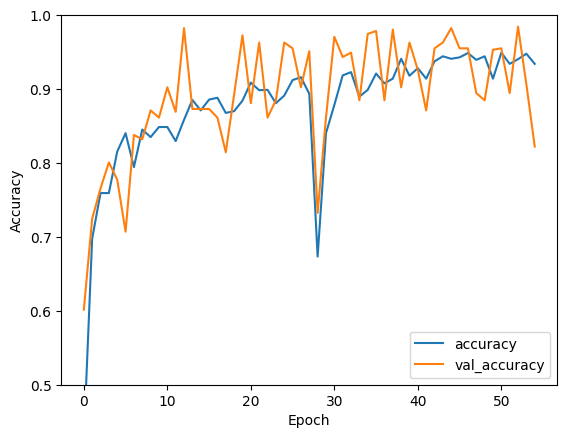

In [25]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [26]:
y_preds = hypermodel.predict(X_test)
y_true = y_test

20/20 [==============================] - 0s 14ms/step


In [27]:
all_y_preds = y_preds.argmax(axis=1)

In [28]:
y_preds = np.array([[val] for val in all_y_preds])

In [29]:
print(classification_report(y_pred=y_preds, y_true=y_true, ))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        96
         1.0       0.81      1.00      0.89        92
         2.0       1.00      1.00      1.00        86
         3.0       1.00      1.00      1.00        69
         4.0       1.00      1.00      1.00        81
         5.0       1.00      1.00      1.00        83
         6.0       1.00      0.65      0.79        63
         7.0       1.00      1.00      1.00        70

    accuracy                           0.97       640
   macro avg       0.98      0.96      0.96       640
weighted avg       0.97      0.97      0.96       640



In [36]:
all_labels = [
    'Steady State', 'Transients', 
    'Incremental load change', 
    'Decremental load change', 
    'Breaker opening', 'Sensor fault', 
    'Stealthy fdia', 'FDIA'
    ]

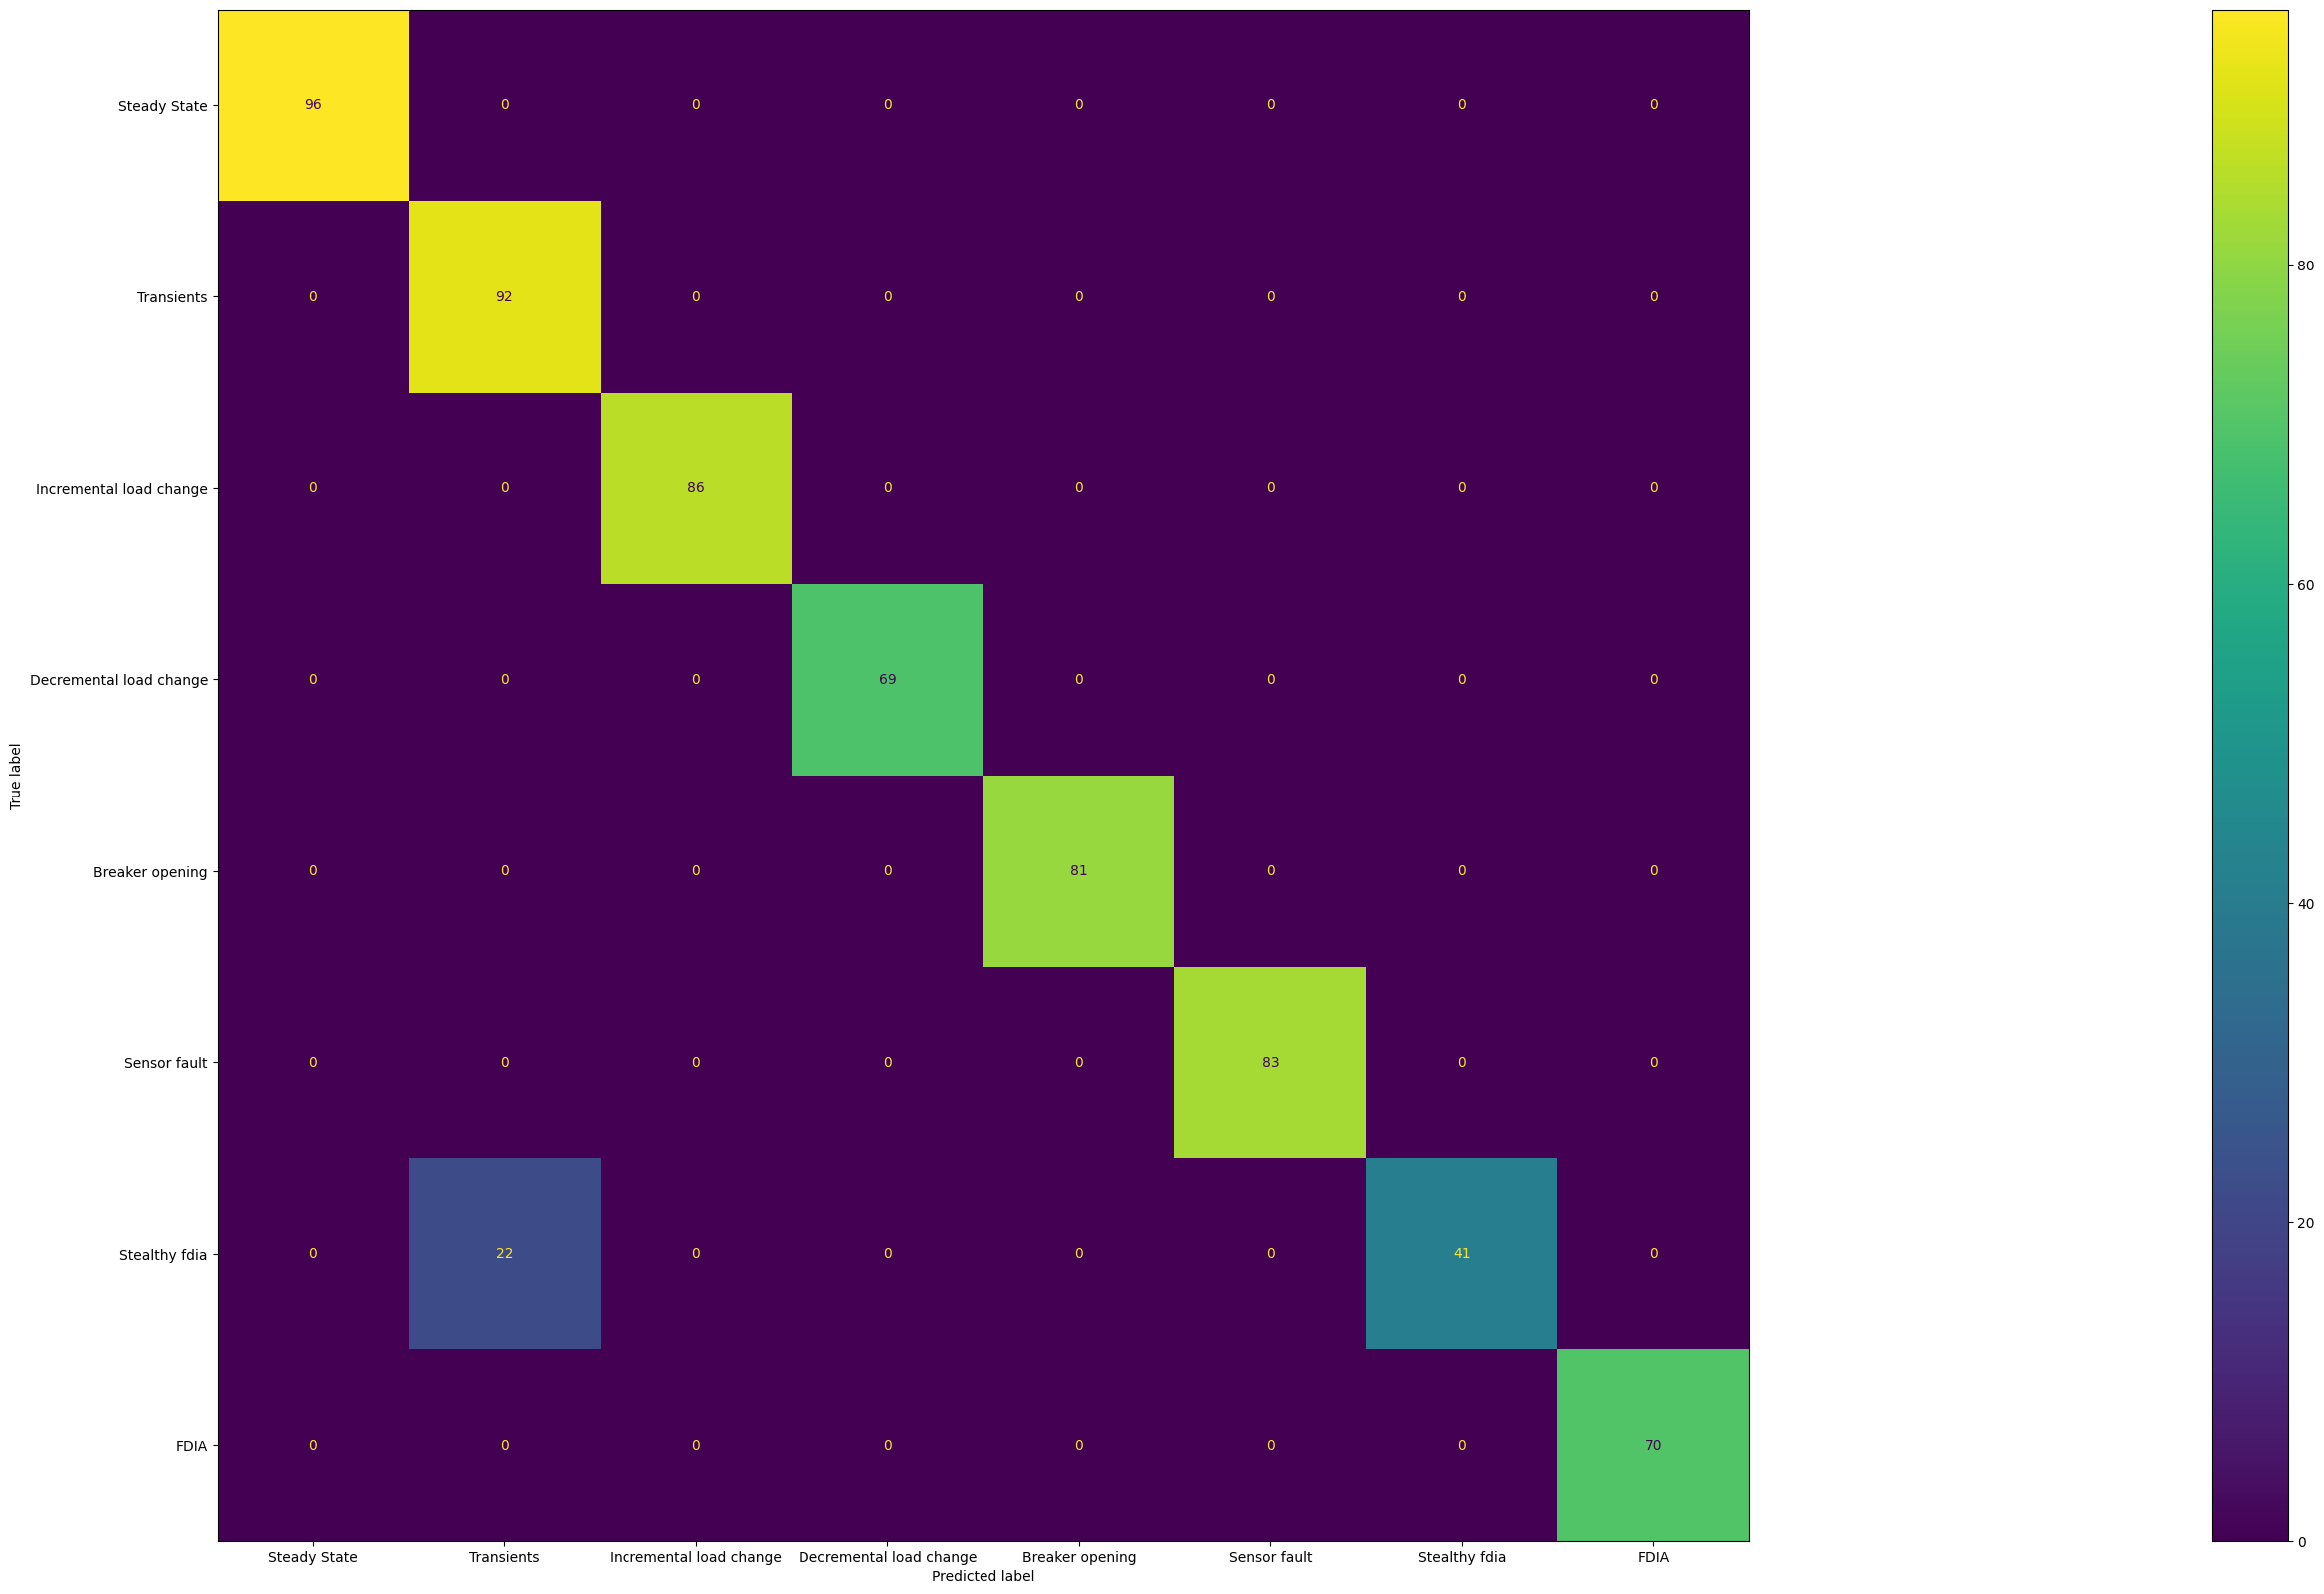

In [72]:
fig, ax = plt.subplots(figsize=(120,20))
cm = confusion_matrix(y_true, y_preds, labels=[0, 1, 2, 3, 4, 5, 6, 7])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_labels,)

disp.plot(ax=ax)